In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from helpers import combine_position_data, log, load_csv, save_csv, calculate_season_average_until_gw
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import root_mean_squared_error, r2_score

In [2]:
data_directory = "Fantasy-Premier-League/data"
seasons = ["2022-23", "2023-24", "2024-25"]
positions = ["DEF", "MID", "FWD"]
output_file_name = "ga_training_data.csv"

log("Combining position data...", level="INFO")
combine_position_data(data_directory, seasons, positions, output_file_name)

Sample of X_train (features):
       value  opponent_defense  own_attack  rolling_adjxg_5  \
8373      50              1340        1130         0.048825   
41166     54              1105        1190         0.044167   
1835      44              1105        1070         0.035258   
9486      45              1130        1150         0.010259   
1142      89              1090        1370         0.143615   

       average_adjxg_season  rolling_shots_5  average_shots_season  
8373               0.000000              0.8              0.000000  
41166              0.059542              0.8              0.636364  
1835               0.053085              0.8              1.000000  
9486               0.079535              0.4              0.857143  
1142               0.339600              2.0              1.833333  
ERROR: RMSE: 0.17393843975183354
ERROR: R-squared: 0.5469938963137672


<Figure size 1000x800 with 0 Axes>

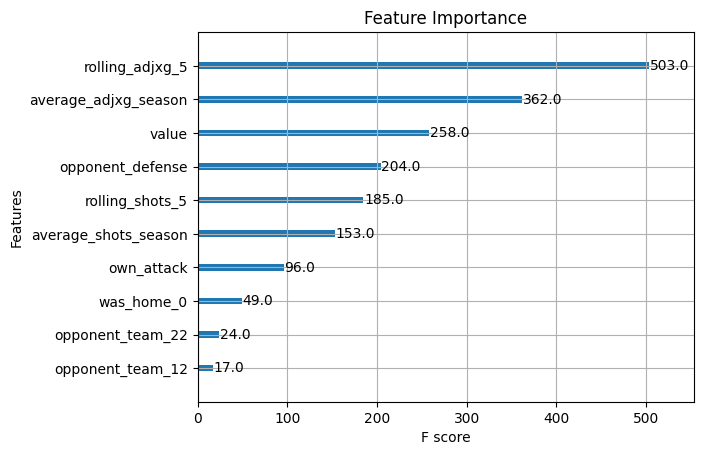

In [3]:
training_data_dir = os.path.join(data_directory, "training_data")
training_file = os.path.join(training_data_dir, output_file_name)
data = load_csv(training_file)
if data is None:
    log("Failed to load training data. Exiting.", level="ERROR")
    exit()

# ========================
# Feature Engineering
# ========================
log("Applying feature engineering...", level="INFO")
MIN_MINUTES = 60

data = data[data['minutes'] >= MIN_MINUTES]

# Remove gameweek 1 from data
data = data[data['gameweek'] > 1]

data['was_home'] = data['was_home'].astype(int)
data = data.sort_values(by=["unique_id", "season", "gameweek"])
data['adjusted_xg'] = data['adjusted_xg'].fillna(0)
data['shots'] = data['shots'].fillna(0)

data['rolling_adjxg_5'] = data.groupby('unique_id')['adjusted_xg'].rolling(window=5, min_periods=1).mean().reset_index(0, drop=True)

data['rolling_shots_5'] = data.groupby('unique_id')['shots'].rolling(window=5, min_periods=1).mean().reset_index(0, drop=True)

data['average_adjxg_season'] = calculate_season_average_until_gw(
    data=data,
    value_column='adjusted_xg',
    group_columns=['unique_id', 'season'],
    current_column='gameweek'
)

data['average_shots_season'] = calculate_season_average_until_gw(
    data=data,
    value_column='shots',
    group_columns=['unique_id', 'season'],
    current_column='gameweek'
)

# One-hot encoding for categorical features
dummy_columns = ["POS", "was_home", "unique_id", "own_team", "opponent_team", "penalties_order"]
data = pd.get_dummies(data, columns=dummy_columns)

# Define features
numerical_features = [
    "value", "opponent_defense", "own_attack",
    "rolling_adjxg_5", "average_adjxg_season", "rolling_shots_5", "average_shots_season"
]
categorical_features = [
    col for col in data.columns if any(col.startswith(f"{dummy_col}_") for dummy_col in dummy_columns)
]
features = numerical_features + categorical_features

TARGET_COLUMN = "adjusted_xg"
X = data[features]
y = data[TARGET_COLUMN]

# ========================
# Train-Test Split
# ========================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Sample of X_train (features):")
print(X_train[numerical_features].head())


# ========================
# Model Training
# ========================
def train_model(X_train, y_train, X_test, y_test):
    log("Training model...", level="INFO")
    try:
        model = XGBRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        log(f"RMSE: {rmse}", level="ERROR")
        log(f"R-squared: {r2}", level="ERROR")
        return model
    except Exception as e:
        log(f"Error during model training: {e}", level="ERROR")
        raise

model = train_model(X_train, y_train, X_test, y_test)

# ========================
# Feature Importance
# ========================
log("Plotting feature importance...", level="INFO")
plt.figure(figsize=(10, 8))
plot_importance(model, max_num_features=10, importance_type="weight")
plt.title("Feature Importance")
plt.show()

# ========================
# Save Model
# ========================
models_folder = "models"
os.makedirs(models_folder, exist_ok=True)
model_path = os.path.join(models_folder, "xgboost_xg_prediction_model.json")
model.save_model(model_path)
log(f"Model saved at: {model_path}", level="INFO")

# ========================
# Optional Hyperparameter Tuning
# ========================
def hyperparameter_tuning(X_train, y_train):
    from sklearn.model_selection import GridSearchCV

    log("Starting hyperparameter tuning...", level="INFO")
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    model = XGBRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=1)
    grid_search.fit(X_train, y_train)

    log(f"Best parameters found: {grid_search.best_params_}", level="INFO")
    log(f"Best RMSE: {-grid_search.best_score_}", level="INFO")
    return grid_search.best_estimator_

# Uncomment to perform tuning
# best_model = hyperparameter_tuning(X_train, y_train)

Sample of X_train (features):
       value  opponent_defense  own_attack  rolling_xa_5  average_xa_season  \
8373      50              1340        1130      0.027178           0.029673   
41166     54              1105        1190      0.010769           0.023608   
1835      44              1105        1070      0.198766           0.146382   
9486      45              1130        1150      0.068700           0.049072   
1142      89              1090        1370      0.562191           0.365321   

       rolling_key_passes_5  average_key_passes_season  rolling_shots_5  \
8373                    1.0                   1.000000              0.8   
41166                   0.2                   0.181818              0.8   
1835                    1.8                   1.625000              0.8   
9486                    0.4                   0.285714              0.4   
1142                    2.8                   2.583333              2.0   

       average_shots_season  
8373          

<Figure size 1000x800 with 0 Axes>

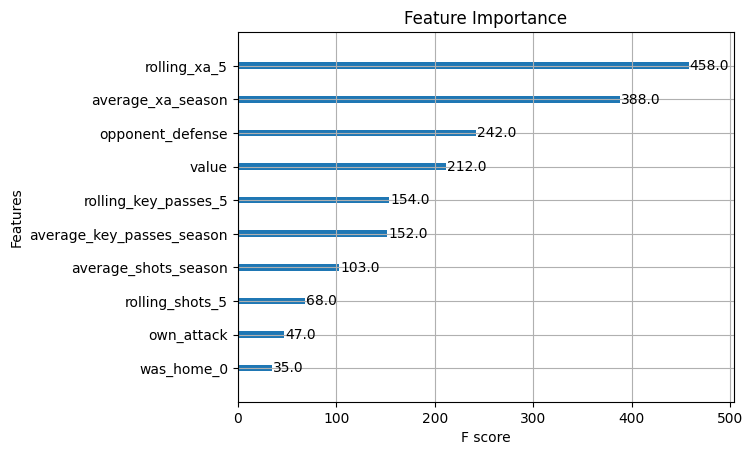

In [4]:
training_data_dir = os.path.join(data_directory, "training_data")
training_file = os.path.join(training_data_dir, output_file_name)
data = load_csv(training_file)
if data is None:
    log("Failed to load training data. Exiting.", level="ERROR")
    exit()

# ========================
# Feature Engineering
# ========================
log("Applying feature engineering...", level="INFO")
MIN_MINUTES = 60

data = data[data['minutes'] >= MIN_MINUTES]

# Remove gameweek 1 from data
data = data[data['gameweek'] > 1]

data['was_home'] = data['was_home'].astype(int)
data['key_passes'] = data['key_passes'].fillna(0)
data['shots'] = data['shots'].fillna(0)
data = data.sort_values(by=["unique_id", "season", "gameweek"])

data['rolling_xa_5'] = data.groupby('unique_id')['expected_assists'].rolling(window=5, min_periods=1).mean().reset_index(0, drop=True)
data['rolling_key_passes_5'] = data.groupby('unique_id')['key_passes'].rolling(window=5, min_periods=1).mean().reset_index(0, drop=True)
data['rolling_shots_5'] = data.groupby('unique_id')['shots'].rolling(window=5, min_periods=1).mean().reset_index(0, drop=True)

data['average_xa_season'] = calculate_season_average_until_gw(
    data=data,
    value_column='expected_assists',
    group_columns=['unique_id', 'season'],
    current_column='gameweek'
)
data['average_key_passes_season'] = calculate_season_average_until_gw(
    data=data,
    value_column='key_passes',
    group_columns=['unique_id', 'season'],
    current_column='gameweek'
)
data['average_shots_season'] = calculate_season_average_until_gw(
    data=data,
    value_column='shots',
    group_columns=['unique_id', 'season'],
    current_column='gameweek'
)

# One-hot encoding for categorical features
dummy_columns = ["POS", "was_home", "unique_id", "own_team", "opponent_team"]
data = pd.get_dummies(data, columns=dummy_columns)

# Define features
numerical_features = [
    "value", "opponent_defense", "own_attack",
    "rolling_xa_5", "average_xa_season", "rolling_key_passes_5", "average_key_passes_season",
    "rolling_shots_5", "average_shots_season"
]
categorical_features = [
    col for col in data.columns if any(col.startswith(f"{dummy_col}_") for dummy_col in dummy_columns)
]
features = numerical_features + categorical_features

TARGET_COLUMN = "expected_assists"
X = data[features]
y = data[TARGET_COLUMN]

# ========================
# Train-Test Split
# ========================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Sample of X_train (features):")
print(X_train[numerical_features].head())

# ========================
# Model Training
# ========================
def train_model(X_train, y_train, X_test, y_test):
    log("Training model...", level="INFO")
    try:
        model = XGBRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        log(f"RMSE: {rmse}", level="ERROR")
        log(f"R-squared: {r2}", level="ERROR")
        return model
    except Exception as e:
        log(f"Error during model training: {e}", level="ERROR")
        raise

model = train_model(X_train, y_train, X_test, y_test)

# ========================
# Feature Importance
# ========================
log("Plotting feature importance...", level="INFO")
plt.figure(figsize=(10, 8))
plot_importance(model, max_num_features=10, importance_type="weight")
plt.title("Feature Importance")
plt.show()

# ========================
# Save Model
# ========================
models_folder = "models"
os.makedirs(models_folder, exist_ok=True)
model_path = os.path.join(models_folder, "xgboost_xa_prediction_model.json")
model.save_model(model_path)
log(f"Model saved at: {model_path}", level="INFO")

# ========================
# Optional Hyperparameter Tuning
# ========================
def hyperparameter_tuning(X_train, y_train):
    from sklearn.model_selection import GridSearchCV

    log("Starting hyperparameter tuning...", level="INFO")
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    model = XGBRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=1)
    grid_search.fit(X_train, y_train)

    log(f"Best parameters found: {grid_search.best_params_}", level="INFO")
    log(f"Best RMSE: {-grid_search.best_score_}", level="INFO")
    return grid_search.best_estimator_

# Uncomment to perform tuning
# best_model = hyperparameter_tuning(X_train, y_train)